In [24]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import collections
import matplotlib.cm as cm
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kirubha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kirubha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kirubha\AppData\Roaming\nltk_data...


In [2]:
# Read the dataset as per the format
data = pd.read_csv("miniproject.csv")
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Exploratory data analysis

1    19314
0     4172
Name: Recommended IND, dtype: int64

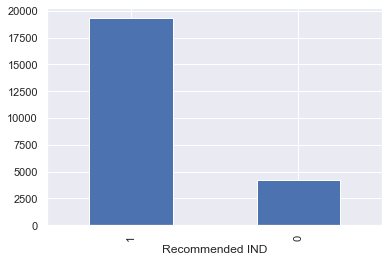

In [3]:
#Recommended IND bar plot
pd.value_counts(data['Recommended IND']).plot.bar()
plt.xlabel('Recommended IND')
data['Recommended IND'].value_counts()

In [4]:
# Extract only the numeric data variables
numDF = pd.DataFrame(data[["Rating", "Recommended IND", "Age", "Positive Feedback Count"]])

# Summary Statistics for all Variables
numDF.describe()

,Rating,Recommended IND,Age,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000
mean,4.196032,0.822362,43.198544,2.535936
std,1.110031,0.382216,12.279544,5.702202
min,1.000000,0.000000,18.000000,0.000000
25%,4.000000,1.000000,34.000000,0.000000
50%,5.000000,1.000000,41.000000,1.000000
75%,5.000000,1.000000,52.000000,3.000000
max,5.000000,1.000000,99.000000,122.000000


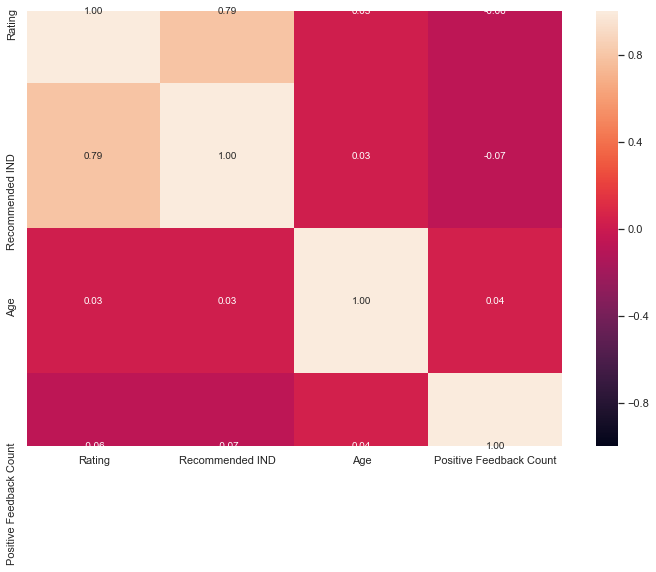

In [5]:
# Calculate the complete  correlation matrix
numDF.corr()
# Heatmap of the Correlation Matrix
f, axes = plt.subplots(1, 1, figsize=(12, 8))
sb.heatmap(numDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

## Data preprocessing

### Preprocess textual data
Processing data from 'Review Text' and 'Title' column

In [6]:
#Removing stopwords and placing the new list of words into a new 'processed review' column

#create empty list
processedtext = []

# Combines words with similar meaning together
stemmer = PorterStemmer()

# Removes words like "it", "an", etc.
sw = stopwords.words("english")

for i in data["Review Text"]:
    i = str(i)
    if i == 'nan':
        i = 'blank'
    text = i.lower()
    words = word_tokenize(i)
    words = [word for word in words if word not in sw]
    words = [stemmer.stem(word) for word in words]
    words = [w for w in words if len(w) > 3]
    words = ' '.join(str(word) for word in words)
    processedtext.append(words)

data = data.join(pd.DataFrame(data = {"processed review" : np.array(processedtext)}))
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,processed review
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretti happen find store glad ...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work initi order p...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit flirti fabul everi tim...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flatter adjust front perfect length wear...


In [7]:
#Removing stopwords and placing the new list of words into a new 'processed title' column

#create empty list
processedtitle = []

# Combines words with similar meaning together
stemmer = PorterStemmer()

# Removes words like "it", "an", etc.
sw = stopwords.words("english")

for i in data["Title"]:
    i = str(i)
    if i == 'nan':
        i = 'blank'
    text = i.lower()
    words = word_tokenize(i)
    words = [word for word in words if word not in sw]
    words = [stemmer.stem(word) for word in words]
    words = [w for w in words if len(w) > 3]
    words = ' '.join(str(word) for word in words)
    processedtitle.append(words)

data = data.join(pd.DataFrame(data = {"processed title" : np.array(processedtitle)}))
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,processed review,processed title
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,blank
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretti happen find store glad ...,blank
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work initi order p...,some major design flaw
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit flirti fabul everi tim...,favorit
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flatter adjust front perfect length wear...,flatter shirt


### Removing unnecessary columns and empty rows

In [8]:
#drop unnecessary columns
data.drop(columns=["Unnamed: 0","Division Name","Class Name"], inplace = True)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,absolut wonder silki sexi comfort,blank
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,love dress sooo pretti happen find store glad ...,blank
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt


In [9]:
data['Review Text'].isnull().sum()

845

In [10]:
data['Title'].isnull().sum()

3810

In [11]:
data['Department Name'].isnull().sum()

14

In [12]:
#dropping empty rows
data = data.dropna(axis=0, subset=['Review Text'])
data = data.dropna(axis=0, subset=['Department Name'])
data = data.dropna(axis=0, subset=['Title'])

In [13]:
#check if removed
data['Review Text'].isnull().sum()

0

In [14]:
#classifying age groups
def agetype(age):
    
    if (0<age<16):
        age = "0-15"
    elif (16<=age<=24):
        age = "16-24"
    elif (25<=age<=54):
        age = "25-54"
    elif (55<=age<=74):
        age = "55-74"
    else: 
        age = ">74"
    return age
        
data['Age Group'] = data['Age'].apply(agetype)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54


In [15]:
data.to_csv(r'test1.csv', index = False)

In [16]:
data = pd.read_csv("test1.csv")

### Visualising textual data using wordcloud

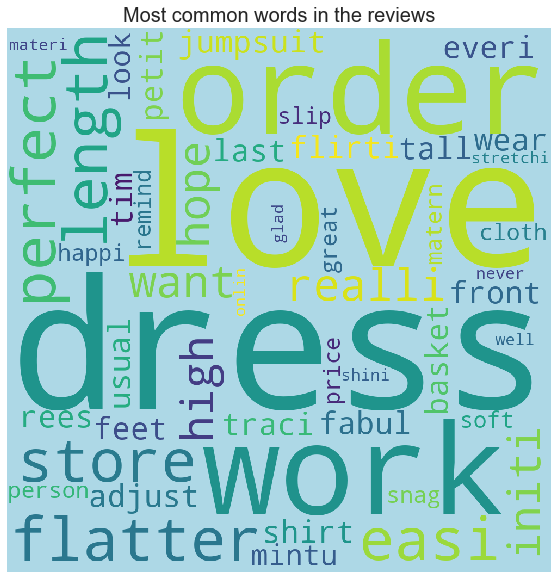

In [17]:
wordcloud = WordCloud(background_color = 'lightblue', width = 1000, height = 1000, max_words = 50).generate(str(data['processed review']))

plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Most common words in the reviews', fontsize = 20)
plt.axis('off')
plt.imshow(wordcloud)

### Positive word count
extracting most common words in reviews with clothing being recommended

<BarContainer object of 30 artists>

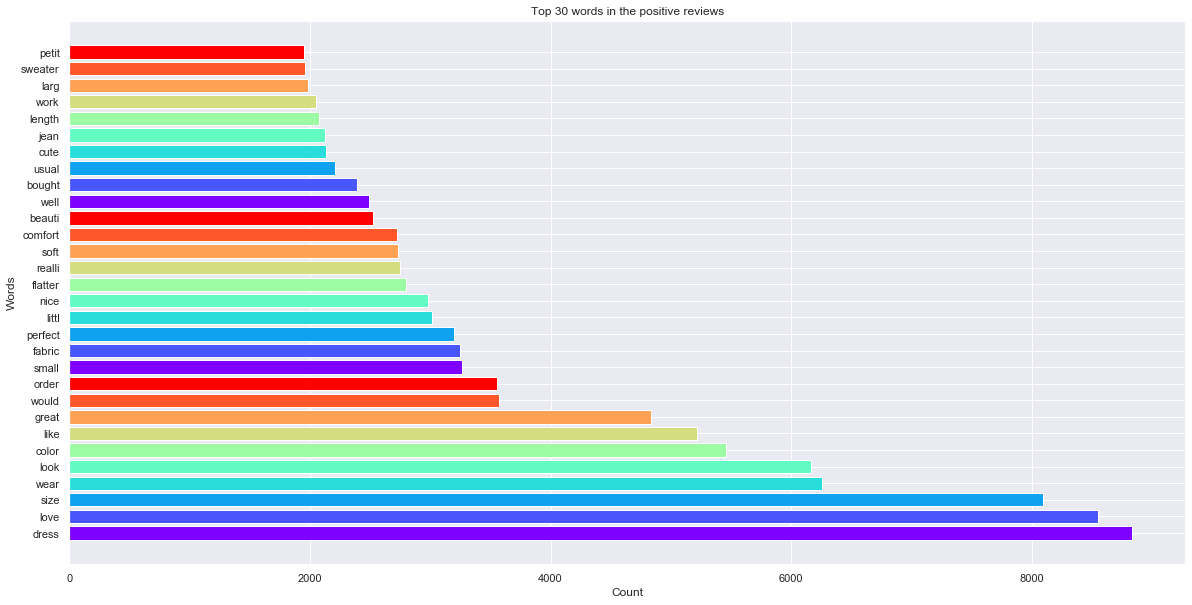

In [18]:
#Frequency bar graph to visualise the top words in processed reviews

all_headlines = ' '.join(data['processed review'][data['Recommended IND']==1].str.lower())
filtered_words = [word for word in all_headlines.split()]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(30):
    words.append(letter)
    counts.append(count)

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top 30 words in the positive reviews')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [19]:
topwords = words
print(topwords)

['dress', 'love', 'size', 'wear', 'look', 'color', 'like', 'great', 'would', 'order', 'small', 'fabric', 'perfect', 'littl', 'nice', 'flatter', 'realli', 'soft', 'comfort', 'beauti', 'well', 'bought', 'usual', 'cute', 'jean', 'length', 'work', 'larg', 'sweater', 'petit']


In [20]:
listb = [] # number of keywords from topwords list found in each row of 'processed review' will be appended to list b
for words in data['processed review']:
    words = word_tokenize(words)
    listb.append(len([word for word in words if word in topwords]))
    
data = data.join(pd.DataFrame(data = {"positive review count" : np.array(listb)}))
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group,positive review count
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74,13
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54,5
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54,6
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54,13
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54,9


### Percentage positive word count

In [21]:
#counting number of words, numw (separated by spaces)
words=[]
for index, row in data.iterrows():
    numw=1
    for x in str(row['Review Text']):
        if x==' ':
            numw+=1
    words.append(numw)
data['num of words']=words
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group,positive review count,num of words
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74,13,98
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54,5,22
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54,6,36
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54,13,98
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54,9,101


In [22]:
#percentage of positive words for each review
percentage=[]
for index, row in data.iterrows():
    percent= (int(row['positive review count'])/int(row['num of words']))*100
    percentage.append(percent)
data['percentage of positive review words(%)']=percentage
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group,positive review count,num of words,percentage of positive review words(%)
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74,13,98,13.265306
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54,5,22,22.727273
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54,6,36,16.666667
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54,13,98,13.265306
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54,9,101,8.910891


### Sentiment Analysis
using VADER (Valence Aware Dictionary and sEntiment Reasoner), which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [25]:
SIA = SentimentIntensityAnalyzer()

#title sentiment
data["processed title"]= data["processed title"].astype(str)
data['Title Polarity Score']=data["Title"].apply(lambda x:SIA.polarity_scores(x)['compound'])
polarity=[]
for index, row in data.iterrows(): 
    if(row['processed title']=='blank'):  #datapoints with no title
        polarity.append('')
    else:
        polarity.append(row['Title Polarity Score'])
data['Title Polarity Score']=polarity

#review sentiment
data["processed review"]= data["processed review"].astype(str)
data['Review Polarity Score']=data["processed review"].apply(lambda x:SIA.polarity_scores(x)['compound'])

data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group,positive review count,num of words,percentage of positive review words(%),Title Polarity Score,Review Polarity Score
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74,13,98,13.265306,0.0000,0.8176
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54,5,22,22.727273,0.5093,0.9674
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54,6,36,16.666667,0.3182,0.8860
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54,13,98,13.265306,0.0000,0.8271
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54,9,101,8.910891,0.5106,-0.0258


### Label Encoding
converting categorcial variables into int

In [26]:
enc = LabelEncoder()
data['encoded age'] = enc.fit_transform(data['Age Group'])
data['encoded clothing ID'] = enc.fit_transform(data['Clothing ID'])
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,processed review,processed title,Age Group,positive review count,num of words,percentage of positive review words(%),Title Polarity Score,Review Polarity Score,encoded age,encoded clothing ID
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,high hope dress realli want work initi order p...,some major design flaw,55-74,13,98,13.265306,0.0000,0.8176,2,973
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,love love love jumpsuit flirti fabul everi tim...,favorit,25-54,5,22,22.727273,0.5093,0.9674,1,945
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,shirt flatter adjust front perfect length wear...,flatter shirt,25-54,6,36,16.666667,0.3182,0.8860,1,750
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,Dresses,love traci rees dress petit feet tall usual we...,petit,25-54,13,98,13.265306,0.0000,0.8271,1,976
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,Tops,basket last mintu would look like person store...,cagrcoal shimmer,25-54,9,101,8.910891,0.5106,-0.0258,1,760


# Classifiers
Response: Recommended IND

Predictors: encoded clothing ID, encoded age, Rating, percentage of positive review words(%), Department Name, Positive Feedback Count, Title Polarity Score, Review Polarity Score

We are using and comparing the Random Forest Classificator, Naive Bayes Classificator and Logistic Regression.

In [27]:
# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID","encoded age", "Department Name","Rating","percentage of positive review words(%)","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (14746, 1) (14746, 8)
Test Set  : (4916, 1) (4916, 8)


### Random oversampling
balance Recommended IND variable

In [28]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

1    12044
0    12044
Name: Recommended IND, dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9425855197608768

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9355166802278275



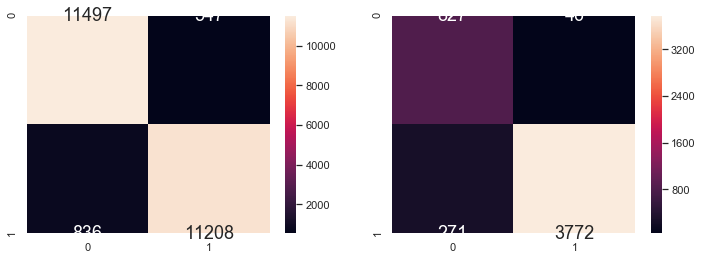

In [29]:
# Import essential models and functions from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

y = pd.DataFrame(data['Recommended IND'])
X = pd.DataFrame(data[["encoded clothing ID","encoded age", "Department Name","Rating","percentage of positive review words(%)","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])

# Random Forest using Train Data
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 4)  # create the object
rforest.fit(X_train, y_train.values.ravel())                         # train the model

# Predict Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rforest.score(X_test, y_test))
print()
rfscore = rforest.score(X_test, y_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [30]:
## Calculating feature importance
feature_importances = pd.DataFrame(rforest.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending = False)
print(feature_importances)

                                        importance
Rating                                    0.669658
Title Polarity Score                      0.246379
Review Polarity Score                     0.047667
percentage of positive review words(%)    0.025533
Positive Feedback Count                   0.004316
encoded clothing ID                       0.002594
encoded age                               0.001252
Department Name_4                         0.001098
Department Name_1                         0.000700
Department Name_2                         0.000423
Department Name_5                         0.000181
Department Name_6                         0.000139
Department Name_3                         0.000059


Train Set : (14746, 1) (14746, 8)
Test Set  : (4916, 1) (4916, 8)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9425855197608768

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9336859235150529



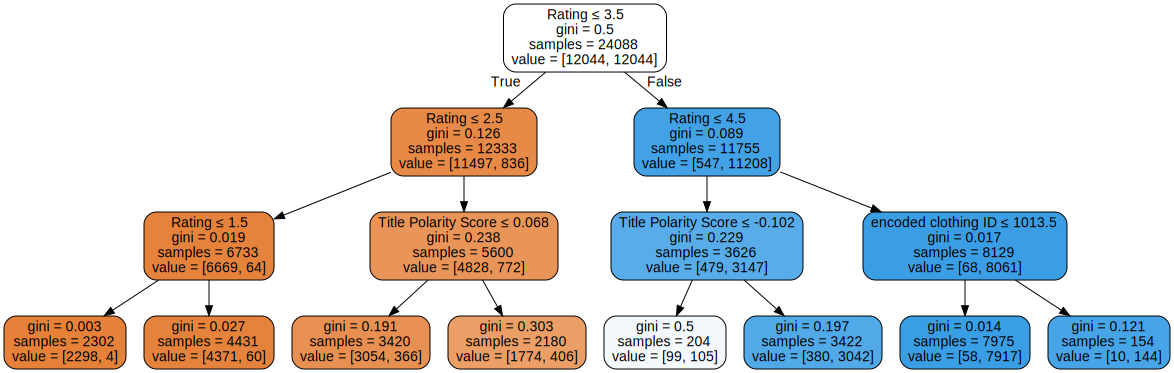

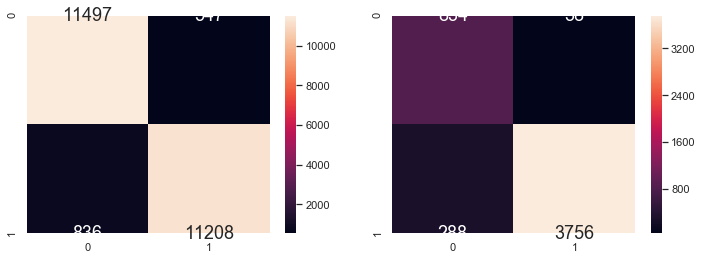

In [31]:
#Decision Tree

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID","encoded age", "Department Name","Rating","percentage of positive review words(%)","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND", axis=1)

#encode department name
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()
decscore=dectree.score(X_test, y_test)

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

graphviz.Source(treedot)

### Naive Bayes Classification

In [32]:
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID","encoded age","Rating","percentage of positive review words(%)","Department Name","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#encoding Department Name 
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

Train Set : (14746, 8) (14746, 1)
Test Set  : (4916, 8) (4916, 1)


1    12043
0    12043
Name: Recommended IND, dtype: int64

In [33]:
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
nbscore = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ',nbscore)

Target on train data [1 1 1 ... 1 0 0]
accuracy_score on train dataset :  0.9254338619945196
Target on test data [1 1 1 ... 1 0 0]
accuracy_score on test dataset :  0.9076484947111473


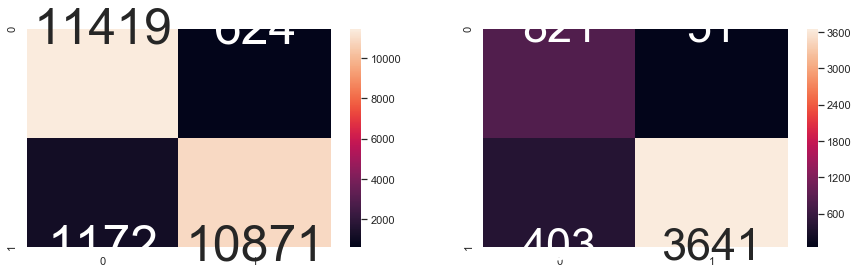

In [34]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(15, 4))
sb.heatmap(confusion_matrix(y_train, predict_train),
           annot = True, fmt=".0f", annot_kws={"size": 50}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, predict_test), 
           annot = True, fmt=".0f", annot_kws={"size": 45}, ax = axes[1])

### Bivariate analysis - Naive Bayes

In [35]:
#department name predictor
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Department Name"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]


# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train, predict_train)
print('accuracy_score on train dataset : ',accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [0 0 0 ... 0 1 0]
accuracy_score on train dataset :  0.5313823163138232
Target on test data [0 0 0 ... 0 1 1]
accuracy_score on test dataset :  0.3659479251423922


In [36]:
#Positive Feedback Count predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Positive Feedback Count"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [1 0 1 ... 1 1 1]
accuracy_score on train dataset :  0.5213710681384347
Target on test data [1 1 1 ... 1 1 1]
accuracy_score on test dataset :  0.7607811228641171


In [37]:
#percentage of positive review words(%) predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["percentage of positive review words(%)"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [0 0 0 ... 0 0 1]
accuracy_score on train dataset :  0.5729538845035314
Target on test data [0 0 0 ... 0 0 0]
accuracy_score on test dataset :  0.43836452400325465


In [38]:
#Rating predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Rating"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [1 1 1 ... 0 0 0]
accuracy_score on train dataset :  0.9422006149754841
Target on test data [1 1 1 ... 1 0 0]
accuracy_score on test dataset :  0.9397884458909682


In [39]:
#Age predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["encoded age"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)
model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [0 0 0 ... 0 0 1]
accuracy_score on train dataset :  0.5196729476218146
Target on test data [0 0 0 ... 0 0 1]
accuracy_score on test dataset :  0.346826688364524


In [40]:
#encoded clothing ID predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["encoded clothing ID"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)
model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [0 1 0 ... 1 0 0]
accuracy_score on train dataset :  0.505271897052719
Target on test data [0 0 0 ... 0 0 1]
accuracy_score on test dataset :  0.24471114727420668


In [41]:
#Title Polarity Score predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Title Polarity Score"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)
model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [1 1 0 ... 0 0 1]
accuracy_score on train dataset :  0.7362391033623911
Target on test data [0 1 0 ... 1 1 1]
accuracy_score on test dataset :  0.7518307567127747


In [42]:
#Review Polarity Score predictor

y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Review Polarity Score"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#Random oversampling
#concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

model = GaussianNB()

# fit the model with the training data
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Target on train data [1 1 1 ... 1 1 1]
accuracy_score on train dataset :  0.6034998753013551
Target on test data [1 1 1 ... 1 1 1]
accuracy_score on test dataset :  0.7605777054515866


Best predictor: Rating

Worst predictor: Encoded clothing ID

## Logistic Regression

In [66]:
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID","encoded age","Rating","percentage of positive review words(%)","Department Name","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#encoding Department Name 
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)

Train Set : (14746, 8) (14746, 1)
Test Set  : (4916, 8) (4916, 1)


C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9423379418826062

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9414157851912124



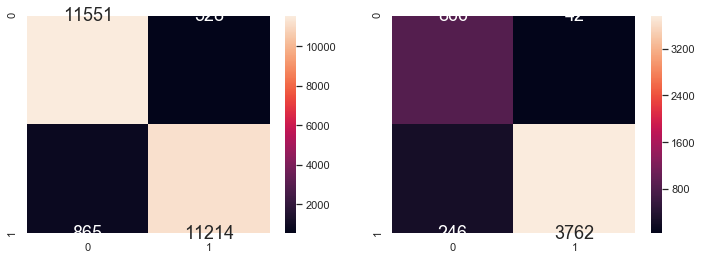

In [67]:
lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()

lrscore = lr.score(X_test, y_test)

#Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Bivariate - Logistic Regression

In [45]:
#encoded clothing id
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["encoded clothing ID"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.4940189400232597

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.47762408462164363



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
#encoded age
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["encoded age"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5159019380486997

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.31651749389747763



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
#encoded dept name
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Department Name"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#encoding Department Name 
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5251141552511416

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.3671684296175753



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
#rating
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Rating"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9450490114636982

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9320585842148088



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
#percentage positive review words
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["percentage of positive review words(%)"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5806451612903226

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5600081366965012



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
#positive feedback count
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Positive Feedback Count"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5344198390976196

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6818551668022783



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
#title polarity score
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Title Polarity Score"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7440807510176954

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7455248169243287



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
#Review polarity score
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data["Review Polarity Score"])
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()

y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


lr = LogisticRegression()
# Fit Random Forest on Train Data
lr.fit(X_train, y_train.values.ravel()) #if doesnt work try y_train.values.ravel()

# Predict AdoptionSpeed 
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", lr.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", lr.score(X_test, y_test))
print()


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6248445144705199

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7054515866558178



C:\Users\Kirubha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Neural Network

In [54]:
import tensorflow as tf
from tensorflow import keras

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID","encoded age", "Department Name","Rating","percentage of positive review words(%)","Positive Feedback Count","Title Polarity Score","Review Polarity Score"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)


model = keras.Sequential([
    keras.layers.Dense(13, input_shape = (13,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()


predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 8)
Test Set  : (4916, 1) (4916, 8)
Train on 23994 samples
Epoch 1/30
23994/23994 [==============================] - 2s 100us/sample - loss: 0.8824 - accuracy: 0.4702
Epoch 2/30
23994/23994 [==============================] - 2s 84us/sample - loss: 0.7044 - accuracy: 0.4976
Epoch 3/30
23994/23994 [==============================] - 2s 68us/sample - loss: 0.6969 - accuracy: 0.4996
Epoch 4/30
23994/23994 [==============================] - 2s 87us/sample - loss: 0.6952 - accuracy: 0.5038
Epoch 5/30
23994/23994 [==============================] - 2s 83us/sample - loss: 0.6944 - accuracy: 0.4955
Epoch 6/30
23994/23994 [==============================] - 2s 83us/sample - loss: 0.6939 - accuracy: 0.5020
Epoch 7/30
23994/23994 [==============================] - 2s 82us/sample - loss: 0.6933 - accuracy: 0.5010
Epoch 8/30
23994/23994 [==============================] - 2s 85us/sample - loss: 0.6931 - accuracy: 0.4961
Epoch 9/30
23994/23994 [==============================

In [55]:
score1 = model.evaluate(X_train, y_train,verbose=1)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", score1[1])

score = model.evaluate(X_test, y_test,verbose=1)
nnscore = score[1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", nnscore)

23994/23994 [==============================] - 1s 39us/sample - loss: 0.6931 - accuracy: 0.5008
Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5007502
4916/4916 [==============================] - 0s 44us/sample - loss: 0.6691 - accuracy: 0.8322
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8321806


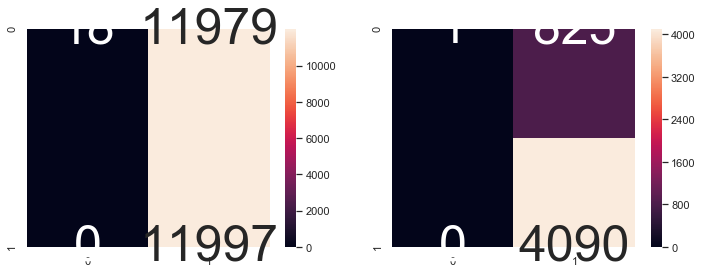

In [56]:
#confusion matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 50}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 50}, ax = axes[1])

### Bivariate analysis - Neural Network 

In [57]:
#Department Name Predictor


# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["Department Name"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)
encoder = ce.OneHotEncoder(cols=['Department Name'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(6, input_shape = (6,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24138 samples
Epoch 1/30
24138/24138 [==============================] - 2s 88us/sample - loss: 0.7595 - accuracy: 0.5128
Epoch 2/30
24138/24138 [==============================] - 2s 65us/sample - loss: 0.6949 - accuracy: 0.5272
Epoch 3/30
24138/24138 [==============================] - 2s 64us/sample - loss: 0.6924 - accuracy: 0.5312
Epoch 4/30
24138/24138 [==============================] - 1s 61us/sample - loss: 0.6919 - accuracy: 0.5275
Epoch 5/30
24138/24138 [==============================] - 2s 68us/sample - loss: 0.6916 - accuracy: 0.5281
Epoch 6/30
24138/24138 [==============================] - 2s 65us/sample - loss: 0.6909 - accuracy: 0.5300
Epoch 7/30
24138/24138 [==============================] - 2s 70us/sample - loss: 0.6911 - accuracy: 0.5305
Epoch 8/30
24138/24138 [==============================] - 1s 57us/sample - loss: 0.6911 - accuracy: 0.5291
Epoch 9/30
24138/24138 [==============================]

In [58]:
#Rating Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["Rating"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24140 samples
Epoch 1/30
24140/24140 [==============================] - 3s 107us/sample - loss: 0.7245 - accuracy: 0.7610
Epoch 2/30
24140/24140 [==============================] - 2s 81us/sample - loss: 0.2577 - accuracy: 0.9415
Epoch 3/30
24140/24140 [==============================] - 2s 76us/sample - loss: 0.1963 - accuracy: 0.9415
Epoch 4/30
24140/24140 [==============================] - 2s 79us/sample - loss: 0.1916 - accuracy: 0.9415
Epoch 5/30
24140/24140 [==============================] - 2s 83us/sample - loss: 0.1899 - accuracy: 0.9415
Epoch 6/30
24140/24140 [==============================] - 2s 84us/sample - loss: 0.1893 - accuracy: 0.9415
Epoch 7/30
24140/24140 [==============================] - 2s 77us/sample - loss: 0.1890 - accuracy: 0.9415
Epoch 8/30
24140/24140 [==============================] - 2s 79us/sample - loss: 0.1887 - accuracy: 0.9415
Epoch 9/30
24140/24140 [==============================

In [59]:
#Review Polarity Score Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["Review Polarity Score"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)

Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24132 samples
Epoch 1/30
24132/24132 [==============================] - 2s 87us/sample - loss: 0.8756 - accuracy: 0.5522
Epoch 2/30
24132/24132 [==============================] - 2s 72us/sample - loss: 0.6662 - accuracy: 0.6234
Epoch 3/30
24132/24132 [==============================] - 2s 75us/sample - loss: 0.6539 - accuracy: 0.6274
Epoch 4/30
24132/24132 [==============================] - 2s 74us/sample - loss: 0.6505 - accuracy: 0.6278
Epoch 5/30
24132/24132 [==============================] - 2s 77us/sample - loss: 0.6489 - accuracy: 0.6285
Epoch 6/30
24132/24132 [==============================] - 2s 82us/sample - loss: 0.6480 - accuracy: 0.6290
Epoch 7/30
24132/24132 [==============================] - 2s 89us/sample - loss: 0.6477 - accuracy: 0.6289
Epoch 8/30
24132/24132 [==============================] - 2s 84us/sample - loss: 0.6473 - accuracy: 0.6290
Epoch 9/30
24132/24132 [==============================]

In [60]:
#Title Polarity Score Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["Title Polarity Score"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24050 samples
Epoch 1/30
24050/24050 [==============================] - 2s 87us/sample - loss: 0.8286 - accuracy: 0.6711
Epoch 2/30
24050/24050 [==============================] - 2s 65us/sample - loss: 0.5414 - accuracy: 0.7442
Epoch 3/30
24050/24050 [==============================] - 2s 74us/sample - loss: 0.5315 - accuracy: 0.7466
Epoch 4/30
24050/24050 [==============================] - 2s 77us/sample - loss: 0.5279 - accuracy: 0.7492
Epoch 5/30
24050/24050 [==============================] - 2s 79us/sample - loss: 0.5254 - accuracy: 0.7498
Epoch 6/30
24050/24050 [==============================] - 2s 74us/sample - loss: 0.5233 - accuracy: 0.7512
Epoch 7/30
24050/24050 [==============================] - 2s 78us/sample - loss: 0.5224 - accuracy: 0.7524
Epoch 8/30
24050/24050 [==============================] - 2s 72us/sample - loss: 0.5216 - accuracy: 0.7538
Epoch 9/30
24050/24050 [==============================]

In [61]:
#percentage of positive review words(%) Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["percentage of positive review words(%)"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24136 samples
Epoch 1/30
24136/24136 [==============================] - 2s 85us/sample - loss: 0.7973 - accuracy: 0.5447
Epoch 2/30
24136/24136 [==============================] - 2s 72us/sample - loss: 0.6845 - accuracy: 0.5807
Epoch 3/30
24136/24136 [==============================] - 2s 62us/sample - loss: 0.6717 - accuracy: 0.5816
Epoch 4/30
24136/24136 [==============================] - 1s 52us/sample - loss: 0.6695 - accuracy: 0.5846
Epoch 5/30
24136/24136 [==============================] - 2s 66us/sample - loss: 0.6695 - accuracy: 0.5816
Epoch 6/30
24136/24136 [==============================] - 2s 73us/sample - loss: 0.6679 - accuracy: 0.5829
Epoch 7/30
24136/24136 [==============================] - 2s 63us/sample - loss: 0.6675 - accuracy: 0.5850
Epoch 8/30
24136/24136 [==============================] - 1s 44us/sample - loss: 0.6676 - accuracy: 0.5830
Epoch 9/30
24136/24136 [==============================]

In [62]:
#encoded age Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded age"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24116 samples
Epoch 1/30
24116/24116 [==============================] - 2s 100us/sample - loss: 0.8870 - accuracy: 0.4991
Epoch 2/30
24116/24116 [==============================] - 2s 75us/sample - loss: 0.7064 - accuracy: 0.5077
Epoch 3/30
24116/24116 [==============================] - 2s 77us/sample - loss: 0.6987 - accuracy: 0.5039
Epoch 4/30
24116/24116 [==============================] - 2s 74us/sample - loss: 0.6957 - accuracy: 0.5099
Epoch 5/30
24116/24116 [==============================] - 2s 75us/sample - loss: 0.6941 - accuracy: 0.5148
Epoch 6/30
24116/24116 [==============================] - 2s 73us/sample - loss: 0.6933 - accuracy: 0.5165
Epoch 7/30
24116/24116 [==============================] - 2s 71us/sample - loss: 0.6925 - accuracy: 0.5218
Epoch 8/30
24116/24116 [==============================] - 2s 76us/sample - loss: 0.6918 - accuracy: 0.5269
Epoch 9/30
24116/24116 [==============================

In [63]:
#encoded clothing ID Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["encoded clothing ID"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24188 samples
Epoch 1/30
24188/24188 [==============================] - 2s 100us/sample - loss: 0.9516 - accuracy: 0.4531
Epoch 2/30
24188/24188 [==============================] - 2s 76us/sample - loss: 0.7103 - accuracy: 0.4947
Epoch 3/30
24188/24188 [==============================] - 2s 72us/sample - loss: 0.7014 - accuracy: 0.4990
Epoch 4/30
24188/24188 [==============================] - 2s 74us/sample - loss: 0.6973 - accuracy: 0.4997s - loss: 0.6974 - accu
Epoch 5/30
24188/24188 [==============================] - 2s 72us/sample - loss: 0.6954 - accuracy: 0.5041
Epoch 6/30
24188/24188 [==============================] - 2s 73us/sample - loss: 0.6948 - accuracy: 0.5016
Epoch 7/30
24188/24188 [==============================] - 2s 78us/sample - loss: 0.6941 - accuracy: 0.5043
Epoch 8/30
24188/24188 [==============================] - 2s 74us/sample - loss: 0.6948 - accuracy: 0.4969
Epoch 9/30
24188/24188 [=======

In [64]:
#Positive Feedback Count Predictor

# Extract Response and Predictors
y = pd.DataFrame(data["Recommended IND"])
X = pd.DataFrame(data[["Positive Feedback Count"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)


#resampling
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X["Recommended IND"]==1]
fraud = X[X["Recommended IND"]==0]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled["Recommended IND"].value_counts()
y_train = upsampled["Recommended IND"]
X_train = upsampled.drop("Recommended IND",axis=1)






model = keras.Sequential([
    keras.layers.Dense(1, input_shape = (1,)),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(10, activation = "sigmoid"),
    keras.layers.Dense(5, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


model.fit(X_train, y_train, epochs = 30, verbose = 1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test acc: ", test_acc)

predictions = model.predict(X_train)
y_train_pred = []

for prediction in predictions:
    y_train_pred.append(np.argmax(prediction))

y_train_pred = pd.DataFrame(np.array(y_train_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
print()

predictions = model.predict(X_test)
y_test_pred = []

for prediction in predictions:
    y_test_pred.append(np.argmax(prediction))

y_test_pred = pd.DataFrame(np.array(y_test_pred))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
print()
nnscore = accuracy_score(y_test, y_test_pred)


Train Set : (14746, 1) (14746, 1)
Test Set  : (4916, 1) (4916, 1)
Train on 24158 samples
Epoch 1/30
24158/24158 [==============================] - 2s 101us/sample - loss: 0.8827 - accuracy: 0.4942
Epoch 2/30
24158/24158 [==============================] - 2s 74us/sample - loss: 0.7000 - accuracy: 0.5427
Epoch 3/30
24158/24158 [==============================] - 2s 75us/sample - loss: 0.6935 - accuracy: 0.5371
Epoch 4/30
24158/24158 [==============================] - 2s 76us/sample - loss: 0.6915 - accuracy: 0.5406
Epoch 5/30
24158/24158 [==============================] - 2s 74us/sample - loss: 0.6904 - accuracy: 0.5409
Epoch 6/30
24158/24158 [==============================] - 2s 75us/sample - loss: 0.6899 - accuracy: 0.5409
Epoch 7/30
24158/24158 [==============================] - 2s 74us/sample - loss: 0.6892 - accuracy: 0.5436s - loss: 0.6895 - accura
Epoch 8/30
24158/24158 [==============================] - 2s 75us/sample - loss: 0.6893 - accuracy: 0.5404
Epoch 9/30
24158/24158 [=====

### Summary of all models used

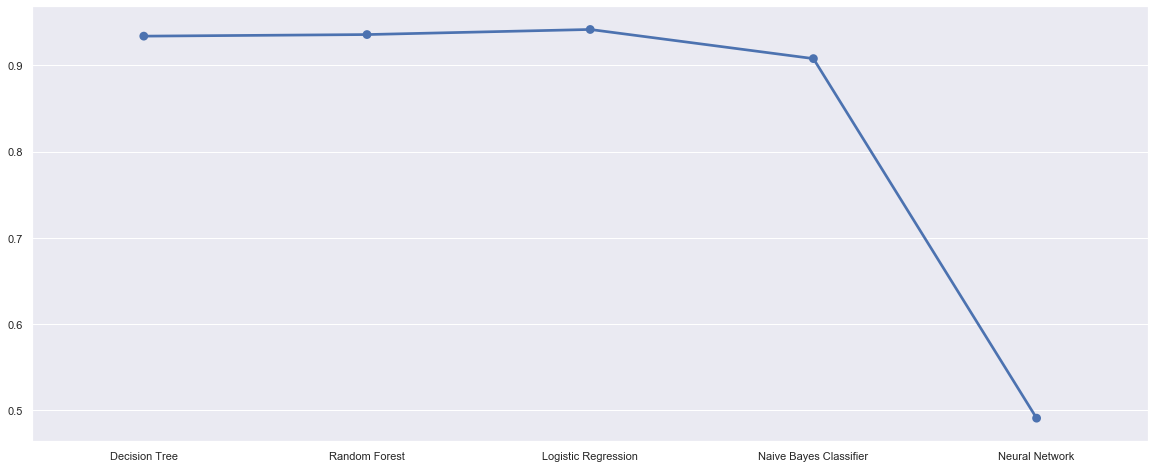

In [68]:
fig, ax1 = plt.subplots(ncols=1, sharey=True,figsize=(20,8))
comparison={
            'Decision Tree':decscore,
            'Random Forest':rfscore,
            'Logistic Regression':lrscore,
            'Naive Bayes Classifier':nbscore,
            'Neural Network':nnscore,
            }
graph = pd.DataFrame(data=comparison,index=[0])
sb.pointplot(data=graph,ax=ax1)

## References

https://blog.statsbot.co/neural-networks-for-beginners-d99f2235efca
https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36
https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
https://www.bmc.com/blogs/keras-neural-network-classification/
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
https://github.com/2796gaurav/Naive-bayes-explained/blob/master/Naive%20bayes/Naive%20Bayes%20in%20scikit%20learn.ipynb
https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf
https://www.statisticssolutions.com/what-is-logistic-regression/
https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
https://scikit-learn.org/stable/modules/feature_selection.html
https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
https://monkeylearn.com/sentiment-analysis/
https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
https://hackernoon.com/choosing-the-right-machine-learning-algorithm-68126944ce1f
https://www.researchgate.net/post/What_is_the_optimal_number_of_iterations_in_a_neural_network_which_also_avoids_over-fitting
https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models
https://www.solver.com/xlminer/help/neural-networks-classification-intro
https://blog.statsbot.co/neural-networks-for-beginners-d99f2235efca
https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/